In [1]:
# --- CELL 1: SETUP & IMPORTS ---
import pandas as pd
import numpy as np
import joblib
import json
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_similarity

# Tentukan lokasi penyimpanan model & data
BASE_DIR = "app/ml"
os.makedirs(BASE_DIR, exist_ok=True)

print(f"✅ Environment siap. Output folder: {BASE_DIR}")

✅ Environment siap. Output folder: app/ml


In [45]:
# --- CELL 2: DATA LOADING & PREPROCESSING ---

# 1. Load Dataset User & Produk
df = pd.read_csv(f"{BASE_DIR}/dummy_ecommerce_clustered.csv")
df_prods = pd.read_csv(f"{BASE_DIR}/products_dummy.csv")

# 2. Fix Column Names (PENTING: Agar UI tidak undefined)
# Frontend butuh 'name', bukan 'product_name'
if "product_name" in df_prods.columns:
    df_prods = df_prods.rename(columns={"product_name": "name"})

# 3. Feature Engineering
# Log Transform pada Monetary agar outlier belanja tinggi tidak merusak skala
df["Monetary_Log"] = np.log1p(df["Monetary"])

# 4. Definisi Fitur untuk Clustering
features = [
    "Recency", "Frequency", "Monetary_Log", "Avg_Items",
    "Unique_Products", "Wishlist_Count", "Add_to_Cart_Count", "Page_Views"
]

# Label yang mudah dibaca untuk Frontend Visualisasi
feature_readable = ["Recency", "Frequency", "Monetary", "Avg Items", "Unique Prod", "Wishlist", "Add Cart", "Views"]

print(f"✅ Data Loaded. User Count: {len(df)}, Product Count: {len(df_prods)}")
print(f"✅ Fitur yang digunakan: {features}")

Loaded: dummy_ecommerce_clustered.csv shape: (800, 12)


,Recency,Frequency,Monetary,Avg_Items,Unique_Products,Wishlist_Count,Add_to_Cart_Count,Page_Views,Preferred_Category,Second_Category,Preferred_Style,True_Cluster
0,17,4,192,2.152577,3,14,5,25,serbaguna,dekor,minimalis,1
1,25,5,619,1.373988,2,2,4,15,gadget,fashion,sporty,2
2,13,8,336,1.616739,2,6,3,18,gadget,gadget,minimalis,2
3,47,4,86,1.693906,3,6,5,23,serbaguna,beauty,minimalis,1
4,81,2,117,1.311473,1,2,1,4,serbaguna,dekor,minimalis,0


In [46]:
# --- CELL 3: SCALING & PCA ---

# 1. Standard Scaling (Z-Score)
# Penting agar fitur satuan besar (Monetary) tidak mendominasi fitur satuan kecil (Frequency)
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. PCA (Principal Component Analysis)
# Mereduksi 8 dimensi fitur menjadi 2 dimensi (x, y) untuk plotting di UI
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Hitung Variance Ratio (seberapa banyak info yang tersimpan di 2D)
pca_var = [round(v * 100, 2) for v in pca.explained_variance_ratio_]

print(f"✅ Data Scaled. PCA Variance Explained: {pca_var}%")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Recency             800 non-null    int64  
 1   Frequency           800 non-null    int64  
 2   Monetary            800 non-null    int64  
 3   Avg_Items           800 non-null    float64
 4   Unique_Products     800 non-null    int64  
 5   Wishlist_Count      800 non-null    int64  
 6   Add_to_Cart_Count   800 non-null    int64  
 7   Page_Views          800 non-null    int64  
 8   Preferred_Category  800 non-null    object 
 9   Second_Category     800 non-null    object 
 10  Preferred_Style     800 non-null    object 
 11  True_Cluster        800 non-null    int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 75.1+ KB


None

,count,mean,std,min,25%,50%,75%,max
Recency,800.0,41.362500,28.162786,5.000000,21.000000,35.000000,49.000000,119.000000
Frequency,800.0,4.568750,2.300954,1.000000,3.000000,4.500000,6.000000,9.000000
Monetary,800.0,246.473750,221.804431,30.000000,90.000000,141.000000,379.750000,798.000000
Avg_Items,800.0,1.997679,0.738176,1.001205,1.410726,1.811589,2.490953,3.984723
Unique_Products,800.0,3.163750,1.462741,1.000000,2.000000,3.000000,4.000000,6.000000
Wishlist_Count,800.0,5.610000,3.904094,0.000000,3.000000,5.000000,8.000000,14.000000
Add_to_Cart_Count,800.0,3.261250,2.018190,0.000000,2.000000,3.000000,5.000000,7.000000
Page_Views,800.0,14.240000,7.014728,3.000000,9.000000,14.000000,19.000000,29.000000
True_Cluster,800.0,1.028750,0.803885,0.000000,0.000000,1.000000,2.000000,2.000000


True_Cluster distribution:
True_Cluster
1    283
2    270
0    247
Name: count, dtype: int64


In [47]:
# --- CELL 4: ELBOW METHOD ---

elbow_curve = {}

# Coba range K dari 2 sampai 9
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    # Inertia = Jarak rata-rata sample ke pusat clusternya (semakin kecil semakin padat)
    elbow_curve[str(k)] = round(km.inertia_, 2)

print("✅ Elbow curve data generated.")

Missing values per column:
Recency               0
Frequency             0
Monetary              0
Avg_Items             0
Unique_Products       0
Wishlist_Count        0
Add_to_Cart_Count     0
Page_Views            0
Preferred_Category    0
Second_Category       0
Preferred_Style       0
True_Cluster          0
dtype: int64
Missing values handled.


In [48]:
# --- CELL 5: CLUSTER ORDERING STRATEGY ---

# 1. Run Initial K-Means
kmeans_temp = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters_temp = kmeans_temp.fit_predict(X_scaled)

# Tambahkan label sementara ke DataFrame
df["Temp"] = clusters_temp

# 2. Urutkan Cluster berdasarkan Rata-rata Belanja (Monetary)
# Cluster 0 = Spending Terendah (Newbie)
# Cluster 3 = Spending Tertinggi (Sultan)
means = df.groupby("Temp")["Monetary_Log"].mean().sort_values()
mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(means.index)}

# 3. Re-arrange Centroids sesuai urutan di atas
sorted_centers = np.zeros_like(kmeans_temp.cluster_centers_)
for old_idx, new_idx in mapping.items():
    sorted_centers[new_idx] = kmeans_temp.cluster_centers_[old_idx]

print(f"✅ Mapping Cluster Index: {mapping}")

Outlier caps applied. Monetary skew after log (describe):


count    800.000000
mean       5.129641
std        0.874326
min        3.496508
25%        4.510860
50%        4.955827
75%        5.942111
max        6.661868
Name: Monetary_Log, dtype: float64

In [49]:
# --- CELL 6: FINAL TRAINING ---

# Init model baru dengan centroid yang sudah diurutkan (sorted_centers)
kmeans_final = KMeans(n_clusters=4, init=sorted_centers, n_init=1, random_state=42)
kmeans_final.fit(X_scaled)

# Prediksi label final untuk semua user
final_clusters = kmeans_final.predict(X_scaled)
df["Cluster"] = df["Temp"].map(mapping)

print("✅ Final K-Means Model Trained & Sorted.")

Feature matrix shape: (800, 8)


,Recency,Frequency,Monetary_Log,Avg_Items,Unique_Products,Wishlist_Count,Add_to_Cart_Count,Page_Views
0,17,4,5.262690,2.152577,3,14,5,25
1,25,5,6.429719,1.373988,2,2,4,15
2,13,8,5.820083,1.616739,2,6,3,18
3,47,4,4.465908,1.693906,3,6,5,23
4,81,2,4.770685,1.311473,1,2,1,4


In [50]:
# --- CELL 7: RECOMMENDATION ENGINE ---

# 1. Vectorize Products (Harga & Kompleksitas)
prod_scaler = MinMaxScaler()
prod_features = df_prods[['price', 'complexity_score']].values
prod_vectors = prod_scaler.fit_transform(prod_features)

# 2. Vectorize User Clusters (Ambil Centroid Monetary & Frequency saja sebagai representasi daya beli)
# Indeks [2, 3] mengacu pada kolom 'Monetary_Log' dan 'Avg_Items' di array centroid (sesuaikan index jika perlu)
# Disini kita pakai approach simplifikasi: menggunakan Price Sensitivity User vs Product Price
centroids = kmeans_final.cluster_centers_
cluster_spending_power = centroids[:, [2, 3]] # Ambil fitur Monetary & Avg Items dari centroid
cluster_vectors = prod_scaler.fit_transform(cluster_spending_power) 

# 3. Hitung Kemiripan (Cosine Similarity)
similarity_matrix = cosine_similarity(cluster_vectors, prod_vectors)

recommendations = {}
cluster_names = ["Newbie", "Window Shopper", "Loyalist", "Sultan"]

# 4. Pilih Top Product untuk setiap Cluster
for i in range(4):
    # Ambil indeks produk dengan skor similarity tertinggi
    top_indices = similarity_matrix[i].argsort()[-6:][::-1]
    
    selected_prods = df_prods.iloc[top_indices].to_dict(orient="records")
    for p in selected_prods:
        p['reason'] = f"Matches {cluster_names[i]} spending profile"
    
    recommendations[i] = selected_prods

print("✅ Product Recommendations Generated.")

Scaler saved to models/scaler_preproc.joblib


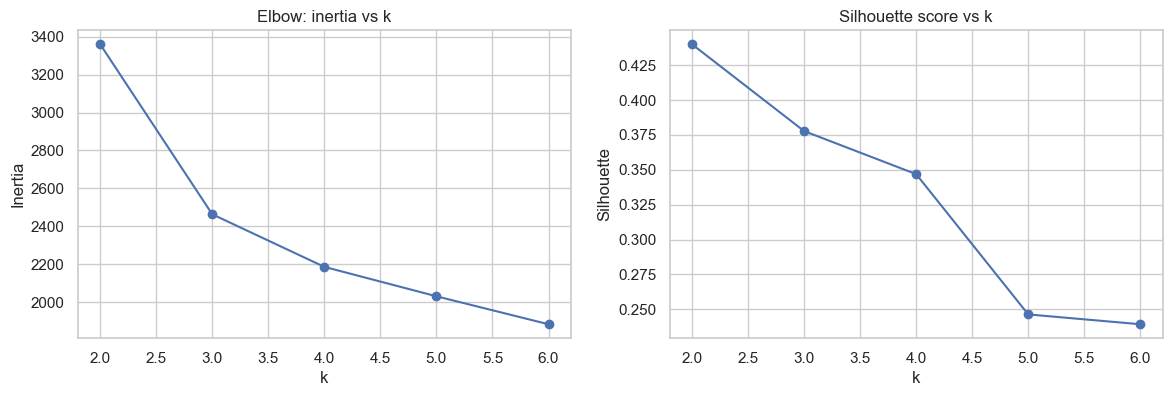

ks & silhouette: [(2, 0.4399), (3, 0.3777), (4, 0.3469), (5, 0.2464), (6, 0.2393)]


In [51]:
# --- CELL 8: ADVANCED VISUALIZATION DATA ---

# A. PCA Scatter Data (Sampling 200 titik agar ringan di browser)
sample_indices = np.random.choice(X_scaled.shape[0], 200, replace=False)
pca_scatter_data = []
for i in sample_indices:
    pca_scatter_data.append({
        "x": round(float(X_pca[i, 0]), 2),
        "y": round(float(X_pca[i, 1]), 2),
        "cluster": int(final_clusters[i])
    })

# B. Feature Correlation Matrix (8x8)
corr_matrix = df[features].corr().round(2).values.tolist()

# C. Silhouette Score per Cluster
sil_samples = silhouette_samples(X_scaled, final_clusters)
sil_per_cluster = []
for i in range(4):
    # Rata-rata silhouette score untuk member di cluster i
    score = sil_samples[final_clusters == i].mean()
    sil_per_cluster.append(round(float(score), 3))

# D. Feature Importance (Global Driver)
# Logika: Fitur dengan nilai centroid absolut terbesar = paling membedakan cluster
feature_importance = np.abs(kmeans_final.cluster_centers_).mean(axis=0)
feat_imp_sorted = sorted(zip(feature_readable, feature_importance), key=lambda x: x[1], reverse=True)

# E. Real Values Centroid (untuk Tabel Deep Dive)
centroids_real = scaler.inverse_transform(kmeans_final.cluster_centers_)
real_df = pd.DataFrame(centroids_real, columns=features)
real_df["Monetary"] = np.expm1(real_df["Monetary_Log"]) # Balikkan log transform
real_df = real_df.drop(columns=["Monetary_Log"])

print("✅ Advanced Metrics Calculated (PCA, Correlation, Importance, Silhouette).")

In [52]:
# --- CELL 9: SAVING ARTIFACTS ---

# 1. Susun Metadata JSON Lengkap
metadata = {
    "silhouette_score": round(silhouette_score(X_scaled, final_clusters), 4),
    "inertia": round(kmeans_final.inertia_, 2),
    "features": features,
    "feature_readable": feature_readable,
    "cluster_names": cluster_names,
    "centroids_scaled": kmeans_final.cluster_centers_.tolist(),
    "centroids_real": real_df.to_dict(orient="records"),
    "cluster_counts": df["Cluster"].value_counts().sort_index().to_dict(),
    "pca_variance": pca_var,
    "elbow_curve": elbow_curve,
    "global_stats": {
        "mean": scaler.mean_.tolist(),
        "std": scaler.scale_.tolist()
    },
    "advanced_viz": {
        "pca_scatter": pca_scatter_data,
        "correlation_matrix": corr_matrix,
        "silhouette_per_cluster": sil_per_cluster,
        "feature_importance": {
            "labels": [x[0] for x in feat_imp_sorted], 
            "data": [round(x[1],2) for x in feat_imp_sorted]
        }
    }
}

# 2. Simpan JSON
with open(f"{BASE_DIR}/model_metrics.json", "w") as f:
    json.dump(metadata, f)

# 3. Simpan Model Joblib
joblib.dump(scaler, f"{BASE_DIR}/scaler_preproc.joblib")
joblib.dump(kmeans_final, f"{BASE_DIR}/kmeans_k2.joblib")
joblib.dump(recommendations, f"{BASE_DIR}/topN_by_cluster.joblib")

print(f"🎉 SUCCESS! All files saved to {BASE_DIR}")
print("1. model_metrics.json (Data Visualisasi)")
print("2. scaler_preproc.joblib (Preprocessing)")
print("3. kmeans_k2.joblib (Model Otak)")
print("4. topN_by_cluster.joblib (Rekomendasi)")

Best by silhouette: 2
Selected k: 2
KMeans(k=2) trained and saved. Cluster counts: Counter({np.int32(1): 553, np.int32(0): 247})
